# InfoTrip BT Data Analysis 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# Import Data - Id76: Neo Risio-Lakoma

In [2]:
# Read data into pandas dataframe
dataset_76_path = r"D:\Mobis Data\InfoTrip\Mobis_data\76.txt"

dateparse = lambda x: pd.datetime.strptime(x, "%y-%m-%d %H:%M:%S")

dataset_76 = pd.read_csv(dataset_76_path, sep='\t', header=0, parse_dates=[2], date_parser = dateparse,
                             names=["Origin", "Destination", "Time stamp", "Mac Address", "Travel Time", "Average Speed",
                                    "Comment #1", "Comment #2"])
dataset_76.describe()

,Origin,Destination,Travel Time,Average Speed
count,239781,239781,188846.000000,157498.000000
mean,76,80,10.441502,97.301804
std,0,0,18.054825,27.027142
min,76,80,0.300000,0.800000
25%,76,80,7.000000,86.700000
50%,76,80,7.900000,100.100000
75%,76,80,9.200000,112.300000
max,76,80,1022.700000,2482.100000


In [3]:
dataset_76.head()

,Origin,Destination,Time stamp,Mac Address,Travel Time,Average Speed,Comment #1,Comment #2
0,76,80,2015-03-09 23:59:17,0008c633e961,7.8,101.0,Trip,NaN
1,76,80,2015-03-10 00:00:06,NaN,NaN,NaN,Check Enough,OK
2,76,80,2015-03-10 00:00:06,001ea4fce8a7,7.4,106.7,Discard Invalid,Too Old
3,76,80,2015-03-10 00:00:06,a8448153cc14,6.5,120.3,Discard Invalid,Too Old
4,76,80,2015-03-10 00:00:06,0016e3a9e349,8.3,94.7,Discard Invalid,Too Old


## Aggregated Values

We collect the 1 hour moving average data.

In [4]:
dataset_76_aggregated = dataset_76[dataset_76["Comment #1"] == "Estimation"]
dataset_76_aggregated.set_index("Time stamp", inplace=True)

In [5]:
dataset_76_aggregated.head()

,Origin,Destination,Mac Address,Travel Time,Average Speed,Comment #1,Comment #2
Time stamp,,,,,,,
2015-03-10 00:08:06,76,80,NaN,9.2,85.5,Estimation,OK
2015-03-10 06:48:06,76,80,NaN,7.3,107.1,Estimation,OK
2015-03-10 06:54:06,76,80,NaN,7.8,101.4,Estimation,OK
2015-03-10 06:59:06,76,80,NaN,8.3,94.8,Estimation,OK
2015-03-10 07:05:07,76,80,NaN,9.2,85.9,Estimation,OK


Add average values

In [6]:
dataset_76_aggregated["Travel Time Avr"] = dataset_76_aggregated["Travel Time"].mean()
dataset_76_aggregated["Average Speed Avr"] = dataset_76_aggregated["Average Speed"].mean()
#dataset_76_aggregated.head()

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Python27\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


### Resample on 1 hour and Fill missing values

In [7]:
free_flow = {"Travel Time": 8, "Average Speed":100}
dataset_76_aggr_resamp = dataset_76_aggregated.resample('1h', how='last')[["Travel Time", "Average Speed"]].fillna(free_flow)
dataset_76_aggr_resamp["Travel Time Avr"] = dataset_76_aggregated["Travel Time"].mean()
dataset_76_aggr_resamp["Average Speed Avr"] = dataset_76_aggregated["Average Speed"].mean()
dataset_76_aggr_resamp.head()

,Travel Time,Average Speed,Travel Time Avr,Average Speed Avr
Time stamp,,,,
2015-03-10 00:00:00,9.2,85.5,8.01725,98.85086
2015-03-10 01:00:00,8.0,100.0,8.01725,98.85086
2015-03-10 02:00:00,8.0,100.0,8.01725,98.85086
2015-03-10 03:00:00,8.0,100.0,8.01725,98.85086
2015-03-10 04:00:00,8.0,100.0,8.01725,98.85086


## Shifted values (Target)

Shifting values 1 hour forward. They will be used as target values to train a model how to predict one hour into the future.

In [8]:
#data[shiftedColumns] = data[columnsToShift].shift(prediction_horizon, freq='H')
dataset_76_aggr_resamp["Travel Time Shifted"] = dataset_76_aggr_resamp["Travel Time"].shift(-1, freq='H')
dataset_76_aggr_resamp["Average Speed Shifted"] = dataset_76_aggr_resamp["Average Speed"].shift(-1, freq='H')
dataset_76_aggr_resamp.dropna(inplace=True)

In [9]:
dataset_76_aggr_resamp.head()

,Travel Time,Average Speed,Travel Time Avr,Average Speed Avr,Travel Time Shifted,Average Speed Shifted
Time stamp,,,,,,
2015-03-10 00:00:00,9.2,85.5,8.01725,98.85086,8,100
2015-03-10 01:00:00,8.0,100.0,8.01725,98.85086,8,100
2015-03-10 02:00:00,8.0,100.0,8.01725,98.85086,8,100
2015-03-10 03:00:00,8.0,100.0,8.01725,98.85086,8,100
2015-03-10 04:00:00,8.0,100.0,8.01725,98.85086,8,100


# Data Anlysis

#### Average number of cars per hour

Average number of records in specific hour of day. Lack of cars bar night is visible. If there are no cars, we replace the "Travel Time" and "Average Speed" with free flow (average).

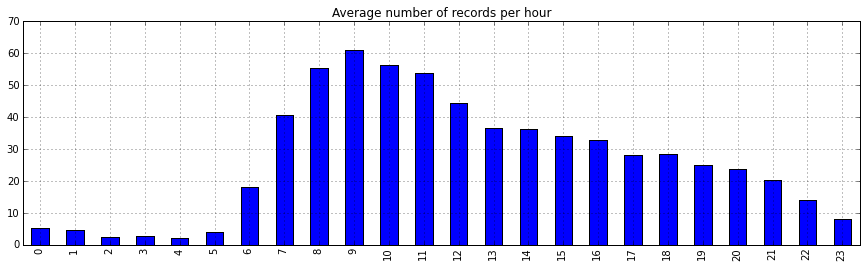

In [10]:
temp_df = dataset_76[dataset_76["Comment #1"] == "Trip"]
temp_df.set_index("Time stamp", inplace=True)
temp_df.groupby([lambda x: x.date, lambda x: x.hour]).count()["Travel Time"].groupby(level=1).mean().plot(
    kind="bar", figsize=(15,4), grid=True, title="Average number of records per hour")

#### Data plot over entire data (Apr-May)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000B9A4F60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B229BA8>], dtype=object)

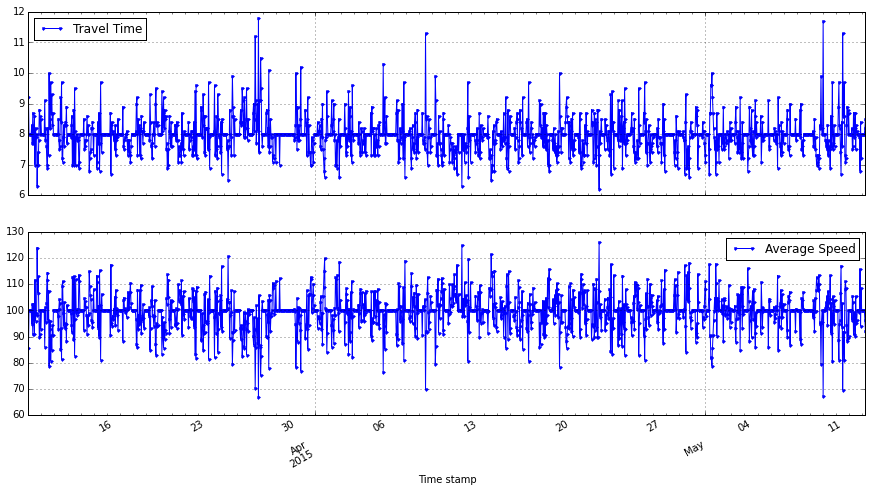

In [11]:
dataset_76_aggr_resamp[["Travel Time", "Average Speed"]].plot(subplots=True, grid=True, figsize=(15,8), style='-b.')

No pattern is visible on this figure. 

#### Data plot over random selected week

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000000DDCEA58>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000000000B62C470>], dtype=object)

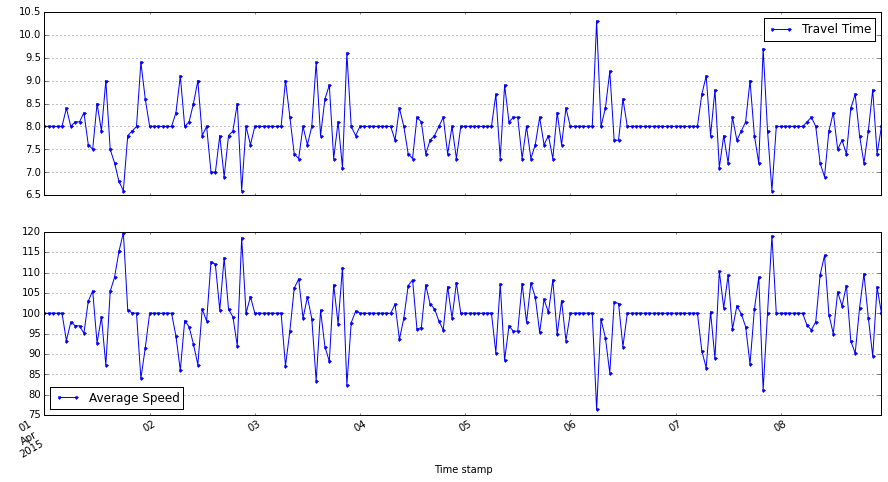

In [12]:
dataset_76_aggr_resamp['2015-04-1':'2015-04-08'][["Travel Time", "Average Speed"]].plot(subplots=True, grid=True,
                                                                                        figsize=(15,8), style='-b.')

Plot shows "Travel Time" and "Average Speed" data over randomly selected week. Beside the lack of data during the night, there is no pattern visible on the figure.

## Week average

Average week was computed in order to find any repeating pattern. 

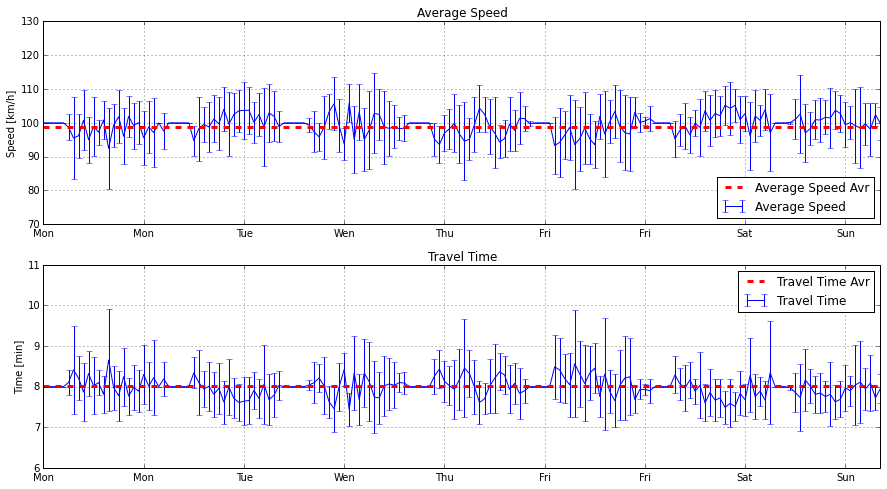

In [13]:
fig, axx = plt.subplots(2, figsize=(15,4*2))

err = dataset_76_aggr_resamp.groupby([dataset_76_aggr_resamp.index.dayofweek, 
                               dataset_76_aggr_resamp.index.hour])["Average Speed"].std()

dataset_76_aggr_resamp.groupby([dataset_76_aggr_resamp.index.dayofweek, 
                               dataset_76_aggr_resamp.index.hour])["Average Speed"].mean().plot(
    ax=axx[0], title="Average Speed", yerr=err, ylim=(70,130), grid=True)

dataset_76_aggr_resamp.groupby([dataset_76_aggr_resamp.index.dayofweek, 
                               dataset_76_aggr_resamp.index.hour])["Average Speed Avr"].mean().plot(ax=axx[0], grid=True,
                                                                                                    style="r--", linewidth=3)

err = dataset_76_aggr_resamp.groupby([dataset_76_aggr_resamp.index.dayofweek, 
                               dataset_76_aggr_resamp.index.hour])["Travel Time"].std()

dataset_76_aggr_resamp.groupby([dataset_76_aggr_resamp.index.dayofweek, 
                               dataset_76_aggr_resamp.index.hour])["Travel Time"].mean().plot(
    ax=axx[1], title="Travel Time", ylim=(6,11), yerr=err, grid=True, style='--g')

dataset_76_aggr_resamp.groupby([dataset_76_aggr_resamp.index.dayofweek, 
                               dataset_76_aggr_resamp.index.hour])["Travel Time Avr"].mean().plot(ax=axx[1], grid=True,
                                                                                                    style="r--", linewidth=3)

axx[0].legend(loc=4)
axx[0].set_ylabel("Speed [km/h]")
axx[0].set_xticklabels(["Mon","Mon","Tue","Wen","Thu","Fri","Fri","Sat","Sun"])

axx[1].legend(loc=1)
axx[1].set_ylabel("Time [min]")
axx[1].set_xticklabels(["Mon","Mon","Tue","Wen","Thu","Fri","Fri","Sat","Sun"])

Similar as before, we can observe repetable lack of data during the night, but during the day, we can observe values variate around the mean value (free flow) with quite low variance. The only visible difference that can be seen during this days of the week, is on the weekends, where Average Speed on average is slightly larger (5km/h), and Travel Time is proportianlly smaller.

### Is traffic any different between days in week (NULL-hypothesis test)?

Looking at the data above, we suspect that traffic is very simillar between all days of the week. For example, traffic on Wensday is the sam as Thusday at the same hour. We want to test this hypothesis:
- **null hypothesis:** Traffic between days in the week is the same
- **alternative test:** Traffic is different between days of the week


P critical is ste to 0.05 in our case.  If p drops bellow this Pcritical then we reject the null hypothesis, else you cannot reject it.

In [14]:
import scipy.stats
import seaborn as sns; sns.set(style="ticks")

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
p_values_days = pd.DataFrame(index=days, columns=days)

for i_idx, i_day in enumerate(days):
    for j_idx, j_day in enumerate(days):
        day1 = dataset_76_aggr_resamp["Average Speed"][dataset_76_aggr_resamp.index.dayofweek == i_idx]
        day2 = dataset_76_aggr_resamp["Average Speed"][dataset_76_aggr_resamp.index.dayofweek == j_idx]
        p = scipy.stats.ttest_ind(day1, day2, equal_var=False)[1]
        p_values_days.loc[i_day][j_day] = round(p, 4)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5]),
 <a list of 7 Text xticklabel objects>)

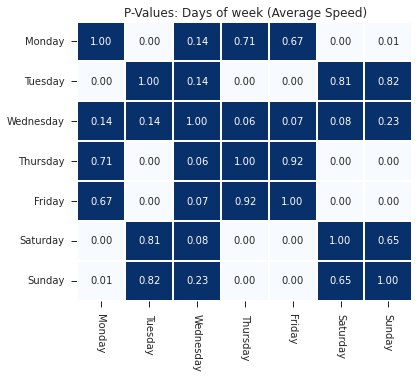

In [15]:
p_values_days = p_values_days[p_values_days.columns].astype(float)
ax = plt.subplots(figsize=(6, 5))
sns.heatmap(p_values_days, annot=True, fmt=".2f", vmin=0.05, vmax=0.06, cbar=False, cmap='Blues')
plt.title("P-Values: Days of week (Average Speed)")
plt.yticks(rotation=0)
plt.xticks(rotation=-90)

Data reveals that indeed many days are very similar. Data during the weekend are similar to each other, and data during week is similar to each other, with one exception of Tuesday (we should check if there is some holiday on Tuesday during the periode of data).

## Day Average

Daily average was also computed, to investigate how traffic is different during the day.

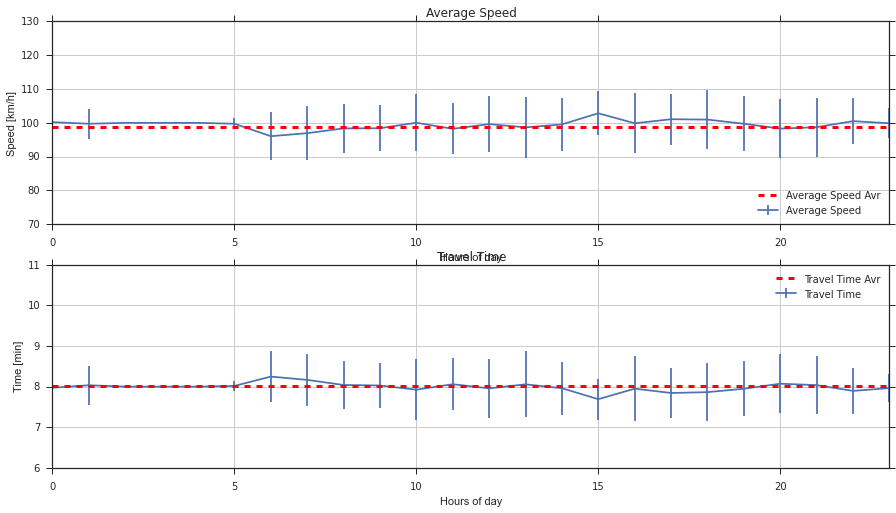

In [16]:
fig, axx = plt.subplots(2, figsize=(15,4*2))

err = dataset_76_aggr_resamp.groupby(dataset_76_aggr_resamp.index.hour)["Average Speed"].std()

dataset_76_aggr_resamp.groupby(dataset_76_aggr_resamp.index.hour)["Average Speed"].mean().plot(
    ax=axx[0], title="Average Speed", yerr=err, ylim=(70,130), grid=True)


dataset_76_aggr_resamp.groupby(dataset_76_aggr_resamp.index.hour)["Average Speed Avr"].mean().plot(ax=axx[0], grid=True,
                                                                                                    style="r--", linewidth=3)

err = dataset_76_aggr_resamp.groupby(dataset_76_aggr_resamp.index.hour)["Travel Time"].std()

dataset_76_aggr_resamp.groupby(dataset_76_aggr_resamp.index.hour)["Travel Time"].mean().plot(
    ax=axx[1], title="Travel Time", ylim=(6,11), yerr=err, grid=True, style='--g')

dataset_76_aggr_resamp.groupby(dataset_76_aggr_resamp.index.hour)["Travel Time Avr"].mean().plot(ax=axx[1], grid=True,
                                                                                                    style="r--", linewidth=3)

axx[0].legend(loc=4)
axx[0].set_ylabel("Speed [km/h]")
axx[0].set_xlabel("Hours of day")

axx[1].legend(loc=1)
axx[1].set_ylabel("Time [min]")
axx[1].set_xlabel("Hours of day")

From the results above, we can observe that average traffic over a day is more or less constantly around the mean value (free flow), with exception of morning rush hour (between 6am - 8am) and afternoon rush hour (3pm - 4pm), where the average traffic slightly deviates from the average (only for about 5km/h - 5%), which is still smaller than the variance.

### Is traffic any different between hours in day (NULL-hypothesis test)?

Looking at the graph above, we also can also suspect that the traffic is very simillar between hours in one day. Same as in previous section, we will test this assumption with NULL hypothesis test:
- **null hypothesis:** Traffic between hours of day is statistically the same
- **alternative test:** Traffic between hours of day is statistically different

P critical is ste to 0.05 in our case.  If p drops bellow this Pcritical then we reject the null hypothesis, else you cannot reject it.

In [17]:
hours = [i for i in range(24)]
p_values_hours = pd.DataFrame(index=hours, columns=hours)

for i_idx, i_day in enumerate(hours):
    for j_idx, j_day in enumerate(hours):
        day1 = dataset_76_aggr_resamp["Average Speed"][dataset_76_aggr_resamp.index.hour == i_idx]
        day2 = dataset_76_aggr_resamp["Average Speed"][dataset_76_aggr_resamp.index.hour == j_idx]
        p = scipy.stats.ttest_ind(day1, day2, equal_var=False)[1]
        p_values_hours.loc[i_day][j_day] = round(p, 4)
#p_values_hours

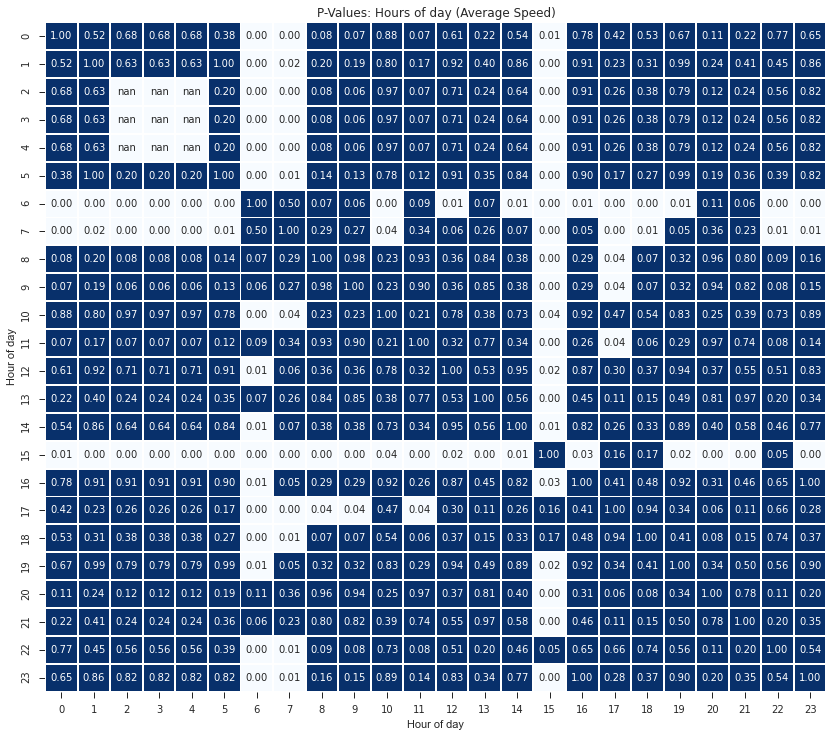

In [18]:
p_values_hours = p_values_hours[p_values_hours.columns].astype(float)
ax = plt.subplots(figsize=(14, 12))
sns.heatmap(p_values_hours, annot=True, fmt=".2f", vmin=0.05, vmax=0.051, cbar=False, cmap='Blues')
plt.title("P-Values: Hours of day (Average Speed)")
plt.xlabel("Hour of day")
plt.ylabel("Hour of day")

From the data (p values) above, it is clearly seen that traffic is statistically similar between all hours of the day, unless between the morning rush hour (from 6am to 8am), and afternoon rush-hour (from 3pm - 4pm)

## Data distribution

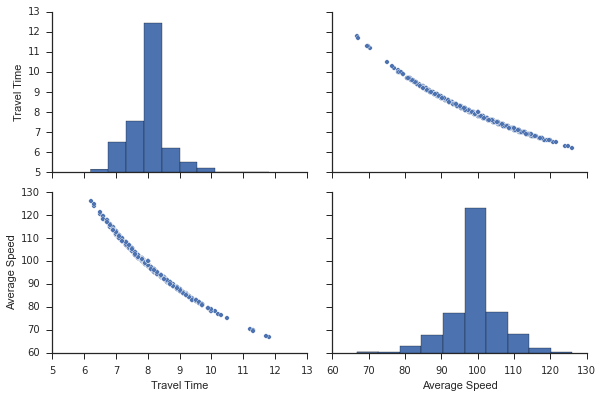

In [19]:
#sns.pairplot(dataset_76_aggr_resamp[['Travel Time','Average Speed','Travel Time Shifted','Average Speed Shifted']], 
#             size=2.8, aspect=1.5)
sns.pairplot(dataset_76_aggr_resamp[['Travel Time','Average Speed']], size=2.8, aspect=1.5)

Both, "Travel Time" and "Average Speed" clearly have normal (Gaussian) distribution, with low variabce. This means that traffic speed is more or less constatly around mean value (free flow) with minor deviations. This is not the case with other traffic variables, such as Flow and Occupancy, which are not available from bluetoth data.

We can also observe linear correlation between Speed and Travel Time (which ofcourse makes sense), but since they are both input variables into a model the correlation is undesirable. Correlated input variables can cause model to perform bad. Input (independent) variables should be uncorelated in order to avoid confusion.

### Corrleations

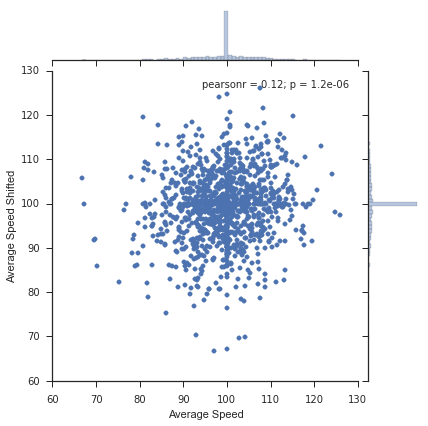

In [20]:
sns.jointplot(x='Average Speed', y='Average Speed Shifted', data=dataset_76_aggr_resamp)

There is very little correlation - almost none (p value - pearson correlation is extremely small) between traffic at time t and t+1.

### Testing Regression

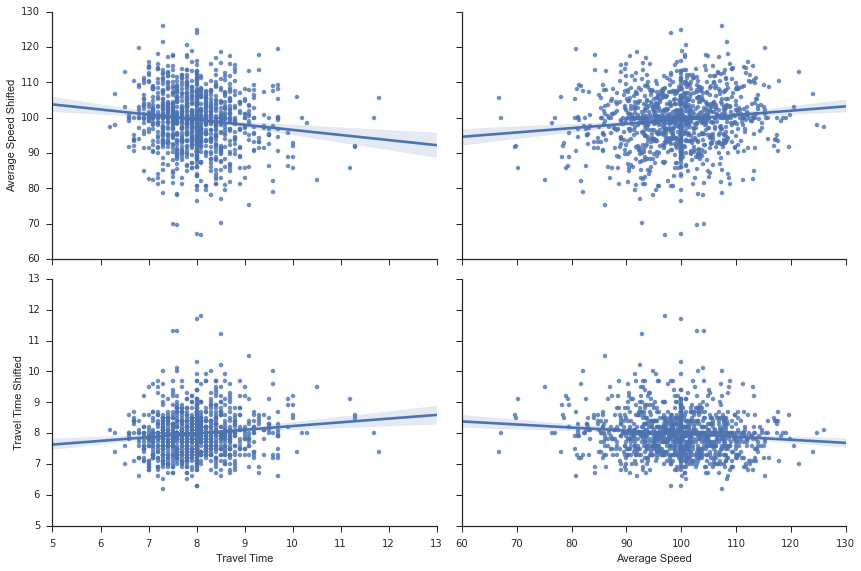

In [21]:
sns.pairplot(dataset_76_aggr_resamp, x_vars=['Travel Time', 'Average Speed'], 
             y_vars=['Average Speed Shifted', 'Travel Time Shifted'],
             size=4, aspect=1.5, kind='reg')

Preliminary regression analysis is done. Again we can observe that there is very little correlation between traffic status t and t+1. From the results we can observe that we are dealing with low variance/high bias - under fitting. This is a well known situation when we have an abundance of data but too few features. One Standard way to improve the performance of such model is by ading more features.

#  Feature Engineering

### Date Time Features

Adding date time features

In [22]:
dataset_76_aggr_resamp["HourOfDay"] = dataset_76_aggr_resamp.index.hour
dataset_76_aggr_resamp["DayOfWeek"] = dataset_76_aggr_resamp.index.dayofweek
dataset_76_aggr_resamp["Weekend"] = dataset_76_aggr_resamp.DayOfWeek.apply(lambda x: 0 if x < 5 else 1)

Adding hourly average Speed values

In [23]:
average = dataset_76_aggr_resamp.groupby([dataset_76_aggr_resamp.index.dayofweek, 
                                          dataset_76_aggr_resamp.index.time])['Average Speed Shifted'].mean()
try:
    dataset_76_aggr_resamp = dataset_76_aggr_resamp.join(pd.DataFrame(average).rename(
            columns={"Average Speed Shifted":"Average Speed Hour Avr"}), 
                                           on=[dataset_76_aggr_resamp.index.dayofweek, 
                                               dataset_76_aggr_resamp.index.time], how = 'left')
except ValueError:
    pass

#dataset_76_aggr_resamp

### Hourly Averages Estimators

Adding hourly average Travel Time values

In [24]:
average = dataset_76_aggr_resamp.groupby([dataset_76_aggr_resamp.index.dayofweek, 
                                          dataset_76_aggr_resamp.index.time])['Travel Time Shifted'].mean()
try:
    dataset_76_aggr_resamp = dataset_76_aggr_resamp.join(pd.DataFrame(average).rename(
            columns={"Travel Time Shifted":"Travel Time Hour Avr"}), 
                                           on=[dataset_76_aggr_resamp.index.dayofweek, 
                                               dataset_76_aggr_resamp.index.time], how = 'left')
except ValueError:
    pass

#dataset_76_aggr_resamp

In [25]:
dataset_76_aggr_resamp.head(2)

,Travel Time,Average Speed,Travel Time Avr,Average Speed Avr,Travel Time Shifted,Average Speed Shifted,HourOfDay,DayOfWeek,Weekend,Average Speed Hour Avr,Travel Time Hour Avr
Time stamp,,,,,,,,,,,
2015-03-10 00:00:00,9.2,85.5,8.01725,98.85086,8,100,0,1,0,100,8
2015-03-10 01:00:00,8.0,100.0,8.01725,98.85086,8,100,1,1,0,100,8


Adding dummy features. From previous empirical experiences, it can also be beneficial for some models, to convert these ordinal variables into dummy/indicator (categorical) variables (i.e. “DayOfWeek” feature 3 is transformed to 0001000).

### Moving Window Aggregates

Mving averages, variances, min, maxs ...

In [26]:
target_cols = ["Travel Time Shifted", "Average Speed Shifted"]

historical_aggr = [
    {'name': '1d', 'periode': 1, 'freq': 'D'},
    {'name': '2d', 'periode': 2, 'freq': 'D'},
    {'name': '1w', 'periode': 7, 'freq': 'D'},
]

for aggr in historical_aggr:
    print "Adding historical aggregates:", aggr['name']
    hist_aggr_cols = [col + "_" + aggr['name'] for col in target_cols]
    dataset_76_aggr_resamp[hist_aggr_cols] = dataset_76_aggr_resamp[target_cols].shift(aggr['periode'], freq=aggr['freq'])
    
dataset_76_aggr_resamp.dropna(inplace=True)

Adding historical aggregates: 1d
Adding historical aggregates: 2d
Adding historical aggregates: 1w


### Dummy Variables

In [27]:
dataset_76_aggr_resamp = dataset_76_aggr_resamp.join(pd.get_dummies(dataset_76_aggr_resamp['HourOfDay'], prefix='dummy_hour'))
dataset_76_aggr_resamp = dataset_76_aggr_resamp.join(pd.get_dummies(dataset_76_aggr_resamp['DayOfWeek'], prefix='dummy_day'))
#df_enriched.head(10)
#df_enriched.dtypes
print 'df_train_dummy shape is ', dataset_76_aggr_resamp.shape

df_train_dummy shape is  (1376, 48)


In [28]:
dataset_76_aggr_resamp.head(2)

,Travel Time,Average Speed,Travel Time Avr,Average Speed Avr,Travel Time Shifted,Average Speed Shifted,HourOfDay,DayOfWeek,Weekend,Average Speed Hour Avr,...,dummy_hour_21,dummy_hour_22,dummy_hour_23,dummy_day_0,dummy_day_1,dummy_day_2,dummy_day_3,dummy_day_4,dummy_day_5,dummy_day_6
Time stamp,,,,,,,,,,,,,,,,,,,,,
2015-03-17 00:00:00,8,100,8.01725,98.85086,8,100,0,1,0,100,...,0,0,0,0,1,0,0,0,0,0
2015-03-17 01:00:00,8,100,8.01725,98.85086,8,100,1,1,0,100,...,0,0,0,0,1,0,0,0,0,0


# Modelling 

In [29]:
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve
from sklearn import metrics
import regression_metrics as additional_metrics
import time

### Methods and Data Sets

We have tested three different data driven methods, from a well-known machine learning library scikit-learn:

- **Ridge Regression:** Computationally nondemanding and fast method; can perform surprisingly well, with proper feature engineering.
- **SVR:** Regression Support Vector Machine is sophisticated non-linear machine-learning method, but can be computationally intense and slow.
- **Random Forests:** An ensemble method that operates by constructing multitude of decision trees. Usually needs some parameter tuning to avoid over-fitting to their training data.

Datasets consists of next set of features:
- **M** - measurements
- **DT** - date time
- **A** - aggregates
- **E** - naive estimator (hourly average)
- **D** - dummy variables

For example DF_M_DT means DataFrame consist of measuremetns features and date time features.

In order to put the results into the perspective, we have included several simple baseline methods. This are simple methods (withour any learned models) which our complex models should outperform:
- **Current Val** - heuristics is that traffic status will remain the same
- **Previous Val** - heuristics is traffic status will be similar at prediction time, as at the same time 1 day before
- **Previous Week** - heuristics is traffic status will be similar at prediction time, as at the same time 1 week before
- **Average** - traffic varaible average over entire dataset
- **Loc Average** - traffic variable average per hour and day of week.

In [30]:
splitting_point = int(0.9 * dataset_76_aggr_resamp.shape[0])
splitting_time = dataset_76_aggr_resamp.iloc[[splitting_point]].index.to_pydatetime()[0]

In [31]:
print "== Training set: ==\n", dataset_76_aggr_resamp[:splitting_time].index.summary()
print "\n== Testing set: ==\n", dataset_76_aggr_resamp[splitting_time:].index.summary()

== Training set: ==
DatetimeIndex: 1239 entries, 2015-03-17 00:00:00 to 2015-05-07 14:00:00
Freq: H

== Testing set: ==
DatetimeIndex: 138 entries, 2015-05-07 14:00:00 to 2015-05-13 07:00:00
Freq: H


Traning dataset (1 month) and testing dataset (1 week) is very small. 

In [32]:
M = ["Travel Time", "Average Speed"]
DT = ["HourOfDay", "DayOfWeek", "Weekend"]
dummy_DT = [col for col in list(dataset_76_aggr_resamp.columns) if col.startswith('dummy')]
#A = []
BL = ["Average Speed Hour Avr","Travel Time Hour Avr", 'Average Speed Shifted_1d', 
      'Average Speed Shifted_1w', 'Average Speed Avr']

In [33]:
models = [{'name': "Ridge Regression", 'init': "linear_model.Ridge()"},
          {'name': "K Nearest Neighbors", 'init': "neighbors.KNeighborsRegressor(n_neighbors = 5)"},
          {'name': "Random Forest", 'init': "RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=8)"},
          #{'name': "SVR", 'init': "svm.SVR(kernel ='rbf', C = 10, gamma = .001)"},
          #{'name': "Neural Network", 'init': "PyBrainNN(hidden_size = 100, learningrate = 0.001, momentum = 0.1, maxEpochs=10)"},
          ]

data_sets = [{'name': 'Current Val (BL)', 'ftrs': "Average Speed", 'target': 'Average Speed Shifted'},
             {'name': 'Previous day (BL)', 'ftrs': "Average Speed Shifted_1d", 'target': 'Average Speed Shifted'},
             {'name': 'Previous week (BL)', 'ftrs': "Average Speed Shifted_1w", 'target': 'Average Speed Shifted'},
             {'name': 'Average (BL)', 'ftrs': "Average Speed Avr", 'target': 'Average Speed Shifted'},
             {'name': 'Loc Average (BL)', 'ftrs': "Average Speed Hour Avr", 'target': 'Average Speed Shifted'},
             {'name': 'DF_M', 'ftrs': M, 'target': 'Average Speed Shifted'},
             {'name': 'DF_M_DT', 'ftrs': M + DT, 'target': 'Average Speed Shifted'},
             {'name': 'DF_M_DT_BL', 'ftrs': M + DT + BL, 'target': 'Average Speed Shifted'},
             {'name': 'DF_M_DDT_BL', 'ftrs': M + dummy_DT + BL, 'target': 'Average Speed Shifted'}]

error_metrics = [
    #{'name': "Explained Variance Score", 'short': "EV", 'function': metrics.explained_variance_score},
    {'name': "Mean Absolute Error", 'short': "MAE", 'function': metrics.mean_absolute_error},
    {'name': "Mean Absolute Percentage Error", 'short': "MAPE", 'function': additional_metrics.mean_absolute_percentage_error},
    {'name': "Mean Squared Error", 'short': "MSE", 'function': metrics.mean_squared_error},
    {'name': "Mean Absolute Scaled Error", 'short': "MASE", 'function': additional_metrics.mean_absolute_scaled_error},
    {'name': "R2 Score", 'short': "R2", 'function': metrics.r2_score}]

#Evaluation 


Training Ridge Regression model...
-->Feature set: DF_M, train score: 0.017, test score: 0.019, runtime: 0.02s
-->Feature set: DF_M_DT, train score: 0.031, test score: 0.013, runtime: 0.00s
-->Feature set: DF_M_DT_BL, train score: 0.190, test score: 0.169, runtime: 0.00s
-->Feature set: DF_M_DDT_BL, train score: 0.193, test score: 0.144, runtime: 0.00s

Training K Nearest Neighbors model...
-->Feature set: DF_M, train score: 0.163, test score: -0.099, runtime: 0.00s
-->Feature set: DF_M_DT, train score: 0.207, test score: -0.127, runtime: 0.01s
-->Feature set: DF_M_DT_BL, train score: 0.331, test score: -0.159, runtime: 0.01s
-->Feature set: DF_M_DDT_BL, train score: 0.362, test score: -0.035, runtime: 0.01s

Training Random Forest model...
-->Feature set: DF_M, train score: 0.110, test score: 0.006, runtime: 0.45s
-->Feature set: DF_M_DT, train score: 0.233, test score: -0.001, runtime: 0.45s
-->Feature set: DF_M_DT_BL, train score: 0.399, test score: 0.096, runtime: 0.49s
-->Feature

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


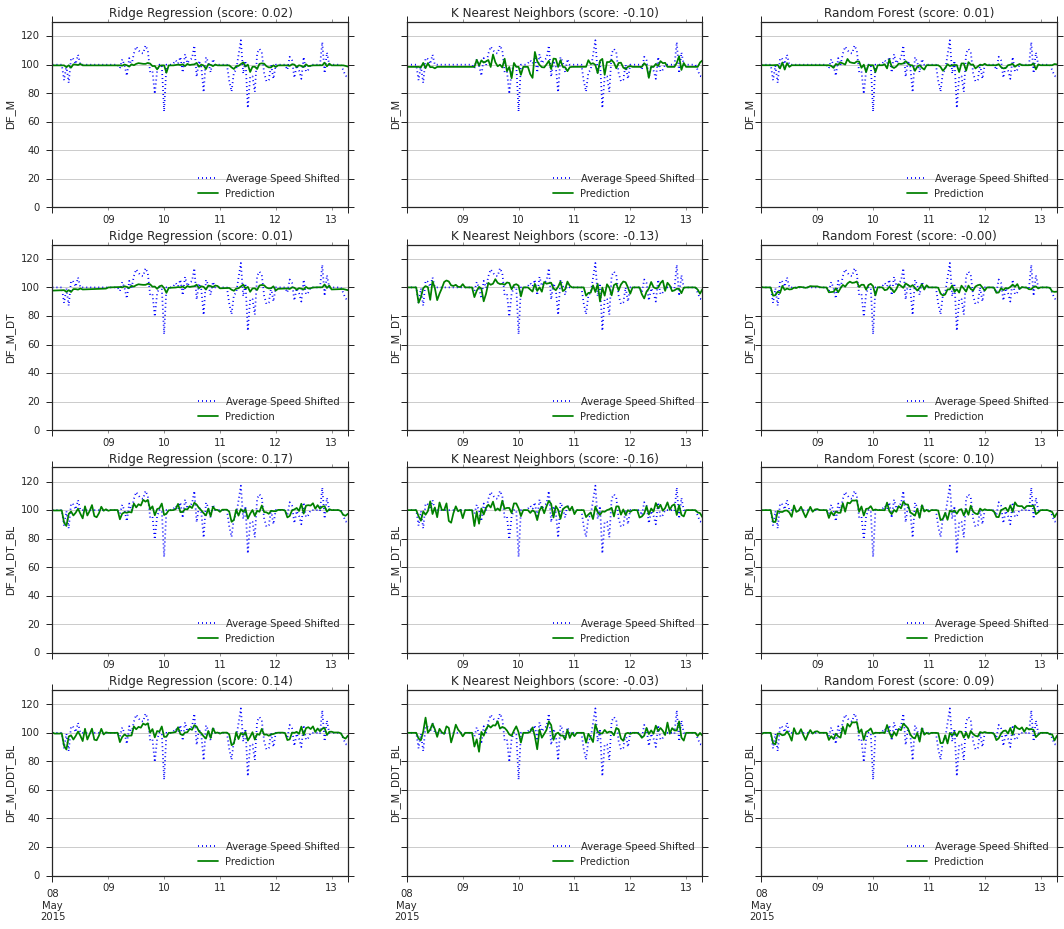

In [34]:
evaluation_results = pd.DataFrame(index=pd.MultiIndex.from_arrays([[],[]]))

f, axx = plt.subplots(len(data_sets[5:]), len(models), sharey=True, sharex=True)
f.set_size_inches(6*len(models),1.7*len(data_sets))

for idx, model in enumerate(models):
    print "\nTraining {} model...".format(model['name'])
    for idy, data_set in enumerate(data_sets):  

        X_train = dataset_76_aggr_resamp[:splitting_time][data_set['ftrs']].values
        y_train = dataset_76_aggr_resamp[:splitting_time][data_set['target']].values.ravel()

        X_test = dataset_76_aggr_resamp[splitting_time:][data_set['ftrs']].values  
        y_test = dataset_76_aggr_resamp[splitting_time:][data_set['target']].values.ravel()

        # Check if we are computing baseline
        if data_set['name'].endswith('(BL)'):
            for metric in error_metrics:
                if metric['short'] == 'MASE':
                    error= metric['function'](y_train,dataset_76_aggr_resamp[:splitting_time][["Average Speed"]].values.ravel(), 
                                               y_test, X_test)
                else:
                    error= metric['function'](y_test, X_test)

                evaluation_results.loc[("Baseline", data_set['name']), metric['short']] = error
            continue

        # Compute this if it is not baseline    
        mdl = eval(model['init'])
        
        start = time.time() # Start measuring time
        mdl.fit(X_train, y_train)
        runtime = time.time() - start # Calculate runtime

        train_score = mdl.score(X_train, y_train)
        test_score = mdl.score(X_test, y_test)
        
        temp = dataset_76_aggr_resamp[splitting_time:]
        temp['Prediction'] = mdl.predict(X_test) 
        ax = temp['2015-05-08':'2015-05-15'][[data_set['target'],'Prediction']].plot(ax = axx[idy-5,idx], grid=True, 
            title = (model['name'] + " (score: %0.2f)" % test_score), style=['b:','g-'], legend=False, ylim=(0,130))
        ax.set_ylabel(data_set['name'])
        ax.set_xlabel("")
        ax.legend(loc=4)
        
        print("-->Feature set: {0}, train score: {1:.3f}, test score: {2:.3f}, runtime: {3:.2f}s".format(
            data_set['name'], train_score, test_score, runtime)) 
        
        for metric in error_metrics:

            if metric['short'] == 'MASE':
                error = metric['function'](y_train, dataset_76_aggr_resamp[:splitting_time][["Average Speed"]].values.ravel(), 
                                           y_test, mdl.predict(X_test))
            else:
                error = metric['function'](y_test, mdl.predict(X_test))

            evaluation_results.loc[(model['name'], data_set['name']), metric['short']] = error
            #print "\t{}: {}".format(metric['short'], error)
            
plt.show()

3 commong machine learning models (Linear Regression, KNN, Random Forests), used for regression problems, were tested on the described data. Figure above shows the prediction results from different learned models (different combinations between methods and feature sets). 

We can see that all the models learned by different methods, perform simillar outputs. Since speed value is more or less the same, we can observe that models with simple features learns more or less mean value, which allready results to small absolute errors. Models learned with additional features tends to predict more speed variations, but far from all. 

In [35]:
evaluation_results

MAE      MAPE         MSE  \
Baseline            Current Val (BL)    5.864493  6.206336   90.219493   
                    Previous day (BL)   6.942029  7.331393  115.785072   
                    Previous week (BL)  6.771739  7.081012   99.104275   
                    Average (BL)        4.857585  5.148056   53.687252   
                    Loc Average (BL)    4.507262  4.787471   45.514279   
Ridge Regression    DF_M                4.559616  4.879490   52.576180   
                    DF_M_DT             4.737119  5.079352   52.923785   
                    DF_M_DT_BL          4.519231  4.806905   44.555230   
                    DF_M_DDT_BL         4.582502  4.872241   45.911386   
K Nearest Neighbors DF_M                5.144928  5.489549   58.948313   
                    DF_M_DT             4.996522  5.336116   60.444255   
                    DF_M_DT_BL          5.436377  5.774811   62.147765   
                    DF_M_DDT_BL         4.985797  5.349522   55.472986   
Random Forest       DF_M                4.519323  4.849452   53.297001   
                    DF_M_DT             4.493398  4.820594   53.655455   
                    DF_M_DT_BL          4.473045  4.784545   48.469412   
                    DF_M_DDT_BL         4.533217  4.846028   48.569312   

                                            MASE        R2  
Baseline            Current Val (BL)    0.962335 -0.682752  
                    Previous day (BL)   1.139154 -1.159594  
                    Previous week (BL)  1.111210 -0.848468  
                    Average (BL)        0.797106 -0.001361  
                    Loc Average (BL)    0.739620  0.151079  
Ridge Regression    DF_M                0.748211  0.019362  
                    DF_M_DT             0.777339  0.012879  
                    DF_M_DT_BL          0.741584  0.168967  
                    DF_M_DDT_BL         0.751967  0.143672  
K Nearest Neighbors DF_M                0.844258 -0.099489  
                    DF_M_DT             0.819905 -0.127391  
                    DF_M_DT_BL          0.892083 -0.159165  
                    DF_M_DDT_BL         0.818145 -0.034668  
Random Forest       DF_M                0.741599  0.005918  
                    DF_M_DT             0.737345 -0.000768  
                    DF_M_DT_BL          0.734005  0.095961  
                    DF_M_DDT_BL         0.743879  0.094097

Evaluations with different error measures are reported in this table, and visualised bellow. The first group of models are the simple baseline methods. Our learned models should outperform this methods. 

We can observe that baseline methods allready have very low absolute error. Mean absolute percentage error (MAPE) is around 6%. The "Local Average (BL)" performs the best among the baseline methods. We used this estimator also as a feature  in dataset (DF_M_DT_BL) to train other models, and we can see that the performance of trained model with this feature is the best with all models. We can also see that our learned models are better than all the baselines, but not significantly better.

But what is concerning is the R2 measure (measure of fitness), which is very low. In statistics, the coefficient of determination, denoted R2 or r2 and pronounced R squared, is a number that indicates how well data fit a statistical model – sometimes simply a line or curve. Closer the value is to 1, better the result. Our best result is only 0.16, which indicates, that even if the absolute error is low, the fitness is very bad, which can also be seen from the previous graph (predictions vs actual results).

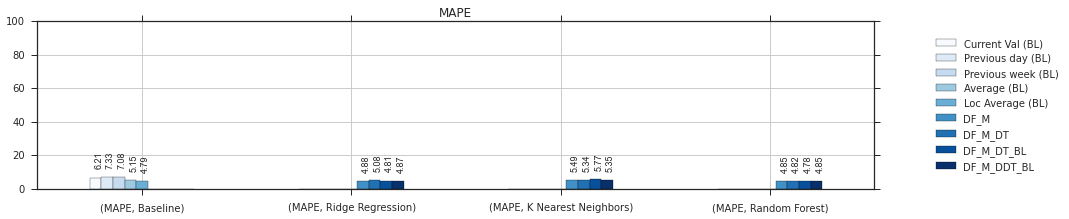

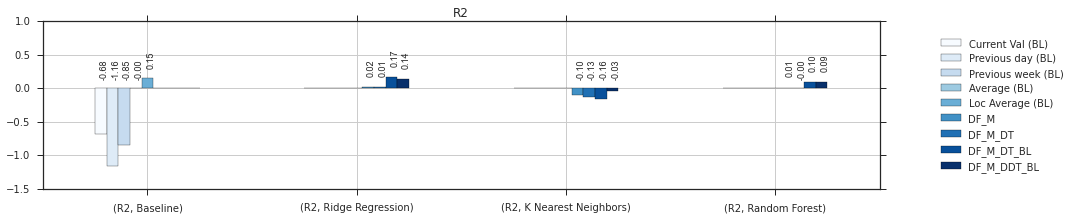

In [36]:
ax = evaluation_results.unstack(0)[['MAPE']].transpose().plot(kind='bar', rot=0, colormap='Blues', ylim=(-0,100), 
                                                         figsize=(15,3),grid=True, title='MAPE')

for p in ax.patches:
    if p.get_height() != 0:
        label = p.get_height() if p.get_y() >= 0 else p.get_height() * -1
        height = p.get_height() + 11 if p.get_y() >= 0 else 11*1.1
        ax.annotate(str("%.2f" % label), (p.get_x()+p.get_width() - 0.01, height), fontsize=9, ha='center', rotation=90)

plt.legend(loc='right', bbox_to_anchor=(1.23, 0.5), ncol=1, fancybox=True, shadow=True)

ax = evaluation_results.unstack(0)[['R2']].transpose().plot(kind='bar', rot=0,ylim=(-1.5,1), colormap='Blues', 
                                                       figsize=(15,3), grid=True, title='R2')

for p in ax.patches:
    if p.get_height() != 0:
        label = p.get_height() if p.get_y() >= 0 else p.get_height() * -1
        height = p.get_height() + 0.3 if p.get_y() >= 0 else 0.3*1.1
        ax.annotate(str("%.2f" % label), (p.get_x()+p.get_width() - 0.01, height), fontsize=9, ha='center', rotation=90)

plt.legend(loc='right', bbox_to_anchor=(1.23, 0.5), ncol=1, fancybox=True, shadow=True)

Results show that we get the best performance with Linear Regression model with DF_M_DT_BL dataset.

##Feature Importance 

-->Feature set: DF_M
-->Feature set: DF_M_DT
-->Feature set: DF_M_DT_BL
-->Feature set: DF_M_DDT_BL


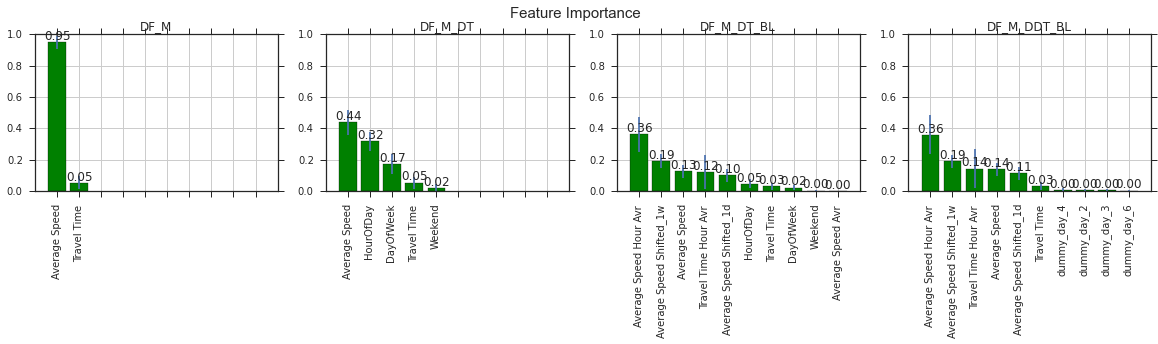

In [37]:
num_of_top_important_ftrs = 10;

fig, axes = plt.subplots(1, len(data_sets[5:]))
fig.set_size_inches(20,3)
plt.suptitle('Feature Importance', fontsize=15)
plt.subplots_adjust(top=.85)
plt.setp(axes, xticks=xrange(num_of_top_important_ftrs), xlim = [-1, num_of_top_important_ftrs], ylim=[0, 1])

model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 10, n_jobs=7)

for idx, data_set in enumerate(data_sets[5:]):
    print "-->Feature set:", data_set['name']
    X = dataset_76_aggr_resamp[:splitting_time][data_set['ftrs']].values
    y = dataset_76_aggr_resamp[:splitting_time][data_set['target']].values.ravel()
    model.fit(X, y)
    
    ds = dataset_76_aggr_resamp[:splitting_time][data_set['ftrs']]
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1][:num_of_top_important_ftrs]
    ftr_size = num_of_top_important_ftrs if ds.shape[1] > num_of_top_important_ftrs else ds.shape[1] 
    
    for f in range(ftr_size):
        axes[idx].annotate( str("%.2f" % importances[indices[f]]), (f, importances[indices[f]] + 0.02), fontsize=12, ha='center')
    
    # Plot the feature importances of the forest
    axes[idx].set_title(data_set['name'])
    axes[idx].bar(xrange(ftr_size), importances[indices], color="g", yerr=std[indices], align="center")
    axes[idx].set_xticklabels(ds.columns[indices], rotation='vertical')
    axes[idx].grid(True)

#fig.tight_layout()
plt.show()

Feature importance shows, that once we include "Loc Average (BL)" values as feature (Average Speed Hour Avr) into our model, this feature is considered as the most important. We have allready seen similar results in Mobis deliverable D3.3.

## Error Analysis 

In order to investigate the learned model and check where we have the biggest errors, we have also performed error analysis. We investigate errors over days of the week for best learned model (Linear Regression with dataset DF_M_DT_BL), and compare them with baseline Current Value for better understanding.

In [38]:
error_df = pd.DataFrame()

data_set = {'name': 'DF_M_DT_BL', 'ftrs': M + DT + BL, 'target': 'Average Speed Shifted'}

X_train = dataset_76_aggr_resamp[:splitting_time][data_set['ftrs']].values
y_train = dataset_76_aggr_resamp[:splitting_time][data_set['target']].values.ravel()

X_test = dataset_76_aggr_resamp[splitting_time:][data_set['ftrs']].values  
y_test = dataset_76_aggr_resamp[splitting_time:][data_set['target']].values.ravel()


# Train the model   
mdl = linear_model.Ridge()

start = time.time() # Start measuring time
mdl.fit(X_train, y_train)
runtime = time.time() - start # Calculate runtime

train_score = mdl.score(X_train, y_train)
test_score = mdl.score(X_test, y_test)

print "Traning model... train score: {0:.3f}, test score: {1:.3f}, runtime: {2:.2f}s".format(train_score, test_score, runtime)

# Compute error
testing_df = dataset_76_aggr_resamp[splitting_time:]
error_df = testing_df[['Average Speed', 'Average Speed Hour Avr']]
error_df['Actual Value'] = testing_df[['Average Speed Shifted']]
error_df['Prediction'] = mdl.predict(X_test)
error_df['LR Prediction Error'] = abs(error_df['Actual Value'] - error_df['Prediction'])
error_df['Current Value (BL) Error'] = abs(error_df['Actual Value'] - error_df['Average Speed'])
error_df['Loc Average (BL) Error'] = abs(error_df['Actual Value'] - error_df['Average Speed Hour Avr'])

#error_df.head()

C:\Python27\lib\site-packages\IPython\kernel\__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\IPython\kernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Python27\lib\site-packages\IPython\kernel\__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Traning model... train score: 0.190, test score: 0.169, runtime: 0.00s


C:\Python27\lib\site-packages\IPython\kernel\__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


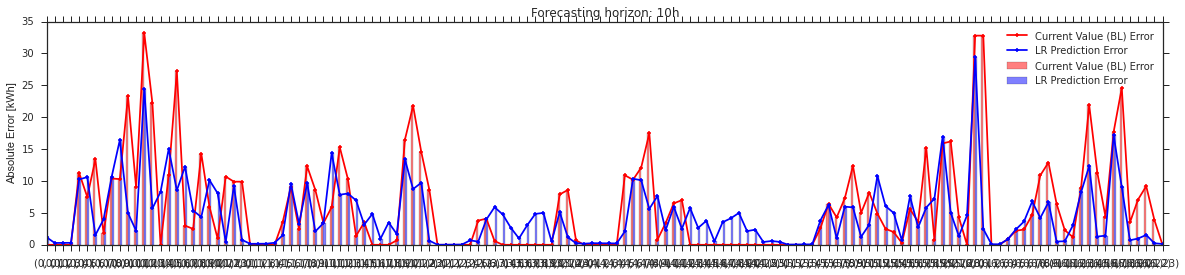

In [39]:
ax = error_df.groupby([error_df.index.dayofweek, error_df.index.hour])['Current Value (BL) Error','LR Prediction Error'].mean().plot(
    kind='bar', figsize=(20,4), color=['r','b'], alpha=0.5)
error_df.groupby([error_df.index.dayofweek, error_df.index.hour])['Current Value (BL) Error', 'LR Prediction Error'].mean().plot(
    ax=ax, figsize=(20,4), style=['r.-','b.-'])

ax.legend()
ax.set_ylabel('Absolute Error [kWh]')
#ax.set_title("Mean errors for main distribution transformer (id12041022)")
ax.set_title("Forecasting horizon: 10h")

On the figure bellow we also added best baseline method ("Loc Average"), and we can see that the errors are very simliar as with our developed model since the importance of the Local Average feature is very hight. Still the errors with our models are sligthly lower, since the model also includes othe feature such as current values.

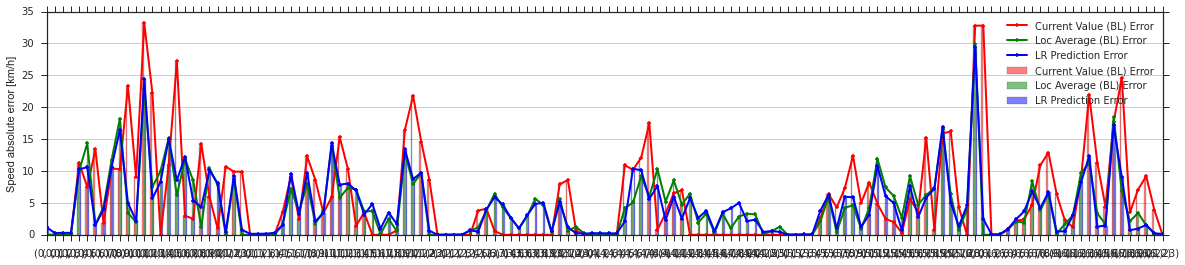

In [40]:
error_cols = ['Current Value (BL) Error', 'Loc Average (BL) Error', 'LR Prediction Error']
ax = error_df.groupby([error_df.index.dayofweek, error_df.index.hour])[error_cols].mean().plot(
    kind='bar', figsize=(20,4), color=['r','g','b',], alpha=0.5)
error_df.groupby([error_df.index.dayofweek, error_df.index.hour])[error_cols].mean().plot(
    ax=ax, figsize=(20,4), style=['r.-','g.-','b.-'], linewidth=2, legend=True)

ax.legend()
ax.set_ylabel('Speed absolute error [km/h]')
ax.yaxis.grid(True)

Overall, it is very important to take in consideration that 1 month and half of data is not enough testing data to draw any serious conclusions.

# Conclusions

- Dataset is to small (1.5 month) to draw any serious conclusions.
- The only predictable pattern that can be learned from this data is the increase of traffic speed (and decrease of travel time) during the weekend. But even this change is very small (3km/h on average).
- Machine learning algorithm cannot learn to predict traffic jams that are note repeatable (no pattern). This traffic jams would have to be investigated why they occure and additional data from which the model could learn the cause of this traffic jams should be integrated. Or to have more data so that some more complex patterns could be learned. 
- We wanted to include also data from other sections, when predicting, to test if there are some obvious correlations (for example if traffic jam is detected on specific section, can the model learn how much after, this traffic jam will occure somewhere else). Unfortunatelly we do not hold enough data from other section to test this.
- All the models (including baselines) have very low absolute error values (MAPE around 5%), but very bad R2 score (best is 0.12). The main reason for this is the nature of data which is normally distributed with very low variance. More data could help increasing the fitness measure R2, but not significantly.
- Traffic speed (or travel time) is a variable that has a clearly normal (Gaussian) distribution, wtih very low variance. This means that traffic speed is more or less constatly around mean value (free flow) with minor deviations, unless there is a severe traffic jam. For example, this is not the case with traffic flow variable (from loop counter data), where value clearly changes over hours of day (and day of week), please see figure bellow. For this reason, traffic speed and travel time cannot have high accuracy of prediction (but can have low MAPE error), as it could be seen from the results.

<img src="traffic_params.png" width="90%" height="90%" align="left"/>